# CNN Model - Data Visualizations

In [64]:
# Load packages
import boto3
import csv
import io
import itertools
import keras
import math
import numpy as np
import os
import pandas as pd
import pickle
import random

from datetime import datetime as dt
from matplotlib import pyplot as plt
from PIL import Image

## Variables and Hyperparameters

In [2]:
###############
## VARIABLES ##
###############

# s3 config
s3_client = boto3.client('s3')
bucket_name = 'hotzone'

# name of directory with fire tif files
tif_directory = "data"

# name of directory with weather data
weather_directory = 'weather_data'

# name of fire direction file
direction_file = 'BBdirectionCA'

# name of fire speed file
speed_file = 'BBspeedCA'

# weather and fire data to include in model
rainint = True
raintot = False
high_t = True
low_t = True
humidity = True
wind_speed = True
wind_direction = True
cloud_cover = False
fire_direction = True
fire_speed = True

weather_variables = {
    'rainint': rainint, 
    'raintot': raintot, 
    'High T': high_t, 
    'Low T': low_t, 
    'Humidity': humidity, 
    'Wind Speed': wind_speed, 
    'Wind Direction': wind_direction, 
    'Cloud Cover': cloud_cover,
    'Fire Direction': fire_direction,
    'Fire Speed': fire_speed
}

weather_vars = []

for k, v in weather_variables.items():
    if v == True:
        weather_vars.append(k)

#####################
## HYPERPARAMETERS ##
#####################

# scale the weather data - yea or nay
normalized_weather = True

# the desired height and width (in pixels) of the matrix to feed into the CNN
# 1 pixel side = 500 meters = 0.310686 miles
matrix_dim = 32

# multiplier for amount of zero-labeled data we want to add to dataset
labeled_multiplier = 24

## Dataset Preprocessing Pipeline

### Download Files from S3 to Local Directory

In [3]:
def pull_fire_data_from_s3(year, tif_directory):
    '''
    Pull files from S3 for the provided year and save to local directory
    '''
    
    file_names = [
        "BBdayofburnCA.tif",
        "BBdirectionCA.tif",
        "BBfireid.tif",
        "BBfirelineCA.tif",
        "BBspeedCA.png",
        "BBspeedCA.tif",
        "ignitioncrop.pickle",
        "polygoncrop.pickle"
    ]
        
    s3 = boto3.resource('s3')
    
    for f in file_names:
        key = "GlobalFire/" + str(year) + "/" + f
        path = '/home/ubuntu/wildfireplus/data/' + f
        
        s3.Bucket('hotzone').download_file(key, path)

In [4]:
def pull_weather_data_from_s3(year, weather_directory):
    '''
    Pull files from S3 for the provided year and save to local directory
    '''
    
    file_name = "weather_data.pickle"
        
    s3 = boto3.resource('s3')
    
    key = "BayAreaWeather/" + str(year) + "/" + file_name
    path = '/home/ubuntu/wildfireplus/weather_data/' + file_name
        
    s3.Bucket('hotzone').download_file(key, path)

### Fire Dataset Preprocessing Functions

In [5]:
def data_processing(directory):
    '''
    Process the dataset in the supplied directory and return matrices of which pixels belong to which fire and 
    which day of the year the pixel was on fire.
    
    Args: 
        - directory: name of directory with tif files
    Returns: 
        - fire_data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by that fire (0, 1)
        - fireline: matrix denoting what day of year that pixel was on fire (1-365)
    '''
    
    path = os.path.abspath(directory)

    tiff_files = []

    for f in os.listdir(path):
        if f.endswith('.tif'):
            tiff_files.append(path + '/' + f)

    tiff_dict = {}

    # dictionary of tiff files
    for f in tiff_files:
        k = f.split('/')[-1].split('.tif')[0]
        tiff_dict[k] = f

    # convert to np array
    fire_id = Image.open(tiff_dict['BBfireid'])
    fire_id = np.array(fire_id)
    fire_id[fire_id == -9999] = 0

    fireline = Image.open(tiff_dict['BBfirelineCA'])
    fireline = np.array(fireline)
    fireline[fireline == -9999] = 0

    # get list of unique fire_ids
    fire_ids = set()

    for row in fire_id:
        for val in row:
            fire_ids.add(val)

    # remove 0 from fire_ids set because it does not denote a fire
    fire_ids.remove(0)

    # get dict with key value pairs of fire_id and an empty dict
    fire_data_dict = {}

    for id in fire_ids:
        id = str(id)
        fire_data_dict[id] = {}

    for id in fire_ids:
        indices = np.where(fire_id == id, 1, 0)
        fire_data_dict[str(id)] = indices
        
    return fire_data_dict, fireline

In [6]:
def create_one_hot_matrices(data_dict, fireline):
    '''
    Create matrices for each fire_id that show were the fire was on a given day during the year.
    
    Args:
        - data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by that fire (0, 1)
        - fireline: matrix denoting what day of year that pixel was on fire (1-365)
    Returns:
        - fire_data_dict: a dictionary of the following structure:
            {
                "fire_id": {
                    "day_of_year": one-hot encoded 2D array of fire spread on that day,
                    "day_of_year": one-hot encoded 2D array of fire spread on that day
                }

            }
    '''
    
    fire_data_dict = {}

    for key, val in data_dict.items():
        data = {}
                
        for y in range(1, 366):
            mask = ((fireline == y) & (val == 1))
            mask = mask.astype(int)
        
            if np.sum(mask) > 0:
                data[str(y)] = mask
        
        fire_data_dict[key] = data
        
    return fire_data_dict

In [7]:
def create_day_pairs(fire_data_dict):
    '''
    Create a list of sets where the first value is where the fire was on a given day and the second value is where
    the fire was on the following day.
    
    Args:
        - fire_data_dict: a dictionary of the following structure:
            {
                "fire_id": {
                    "day_of_year": one-hot encoded 2D array of fire spread on that day,
                    "day_of_year": one-hot encoded 2D array of fire spread on that day
                }

            }
    Returns:
        - train_labels: a list of sets where the first value of the set is a one-hot encoded 2D array of fire 
        spread on day_1 and the second value of the set is a one-hot encoded 2D array of fire spread on day_2:
        [
            (one-hot encoded 2D array of fire spread on that day_1, one-hot encoded 2D array of fire spread on day_2),
            (one-hot encoded 2D array of fire spread on that day_2, one-hot encoded 2D array of fire spread on day_3),
        ]
    '''
    
    train_labels = []

    for key, value in fire_data_dict.items():
        burn_matrices = list(value.values())
        day_of_year = list(value.keys())
        
        for index, day in enumerate(burn_matrices):

            if index < len(burn_matrices) - 1:
                day_1 = burn_matrices[index]
                day_2_index = index + 1
                day_2 = burn_matrices[day_2_index]
                
                doy = day_of_year[day_2_index]
                
                pair = (day_1, day_2)
                train_labels.append((doy, pair))

    return train_labels

In [8]:
def process_fire_data_tiff(directory, file):
    '''
    Process the fire data in the supplied tiff file and return a dictionary of key day of year and value a matrix 
    making up the attribute of that tiff file

    Args:
        - directory: name of directory of supplemental data
        - file: name of tiff file of supplemental data to add to model
    Returns:
        - fire_data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by the attribute of interest
    '''
    
    path = os.path.abspath(directory)

    tiff_files = []

    for f in os.listdir(path):
        if f.endswith('.tif'):
            tiff_files.append(path + '/' + f)

    tiff_dict = {}

    # dictionary of tiff files
    for f in tiff_files:
        k = f.split('/')[-1].split('.tif')[0]
        tiff_dict[k] = f
        
    # convert day of burn tif to np array
    fire_dob = Image.open(tiff_dict['BBdayofburnCA'])
    fire_dob = np.array(fire_dob)
    fire_dob[fire_dob == -9999] = 0

    # convert tif of interest to np array
    fire_data_mat = Image.open(tiff_dict[file])
    fire_data_mat = np.array(fire_data_mat)
    fire_data_mat[fire_data_mat == -9999] = 0
    
    # get list of unique days of burn
    days_of_burn = list(np.unique(fire_dob))

    # remove 0 from days of burn because it does not denote a fire
    days_of_burn.remove(0)
        
    # get dict with key value pairs of fire_id and an empty dict
    fire_data_dict = {}

    for idx in days_of_burn:
        idx = int(idx)
        
        mask = (fire_dob == idx)        
        mask = mask.astype(int)
        
        values = np.multiply(mask, fire_data_mat)
        
        idx = str(idx)
        fire_data_dict[idx] = {}
        fire_data_dict[idx]['Fire Direction'] = values 

    
    return fire_data_dict

In [9]:
def process_fire_data_png(directory, file):
    '''
    Process the fire data in the supplied png file and return a dictionary of key day of year and value a matrix 
    making up the attribute of that png file

    Args:
        - directory: name of directory of supplemental data
        - file: name of png file of supplemental data to add to model
    Returns:
        - fire_data_dict: a dictionary where the key is "fire_id" and the value is a matrix of pixels 
        triggered by the attribute of interest
    '''
    
    path = os.path.abspath(directory)

    tiff_files = []
    png_files = []
    
    for f in os.listdir(path):
        if f.endswith('.tif'):
            tiff_files.append(path + '/' + f)

    for f in os.listdir(path):
        if f.endswith('.png'):
            png_files.append(path + '/' + f)
    
    tiff_dict = {}
    png_dict = {}

    # dictionary of tiff files
    for f in tiff_files:
        k = f.split('/')[-1].split('.tif')[0]
        tiff_dict[k] = f
    
    for f in png_files:
        k = f.split('/')[-1].split('.png')[0]
        png_dict[k] = f
        
    # convert day of burn tif to np array
    fire_dob = Image.open(tiff_dict['BBdayofburnCA'])
    fire_dob = np.array(fire_dob)
    fire_dob[fire_dob == -9999] = 0

    # convert png of interest to np array
    fire_data_mat = Image.open(png_dict[file])
    fire_data_mat = np.array(fire_data_mat)
    fire_data_mat[fire_data_mat == -9999] = 0
    
    # get list of unique days of burn
    days_of_burn = list(np.unique(fire_dob))

    # remove 0 from days of burn because it does not denote a fire
    days_of_burn.remove(0)
        
    # get dict with key value pairs of fire_id and an empty dict
    fire_data_dict = {}

    for idx in days_of_burn:
        idx = int(idx)
        
        mask = (fire_dob == idx)        
        mask = mask.astype(int)
        
        values = np.multiply(mask, fire_data_mat)
        
        idx = str(idx)
        fire_data_dict[idx] = {}
        fire_data_dict[idx]['Fire Speed'] = values 

    
    return fire_data_dict

In [10]:
def combine_dicts(dict_1, dict_2):
    '''
    A helper function to combine the values of two dictionaries that have the same keys.
    
    Args:
        - dict_1: a dictionary of key day of year, and value a dictionary of key fire attribute and value a matrix
        denoting where that attribute is triggered
        - dict_2: a dictionary of key day of year, and value a dictionary of key fire attribute and value a matrix
        denoting where that attribute is triggered
    Returns:
        - dict_2: combined dictionary of dict_1 and dict_2
    '''
      
    for k, v in dict_1.items():
        for att, mat in v.items():
            dict_2[k][att] = mat
            
    return dict_2

### Weather Data Preprocessing Functions

In [11]:
def create_weather_dict(directory, normalized_weather, weather_vars, fire_data_dict):
    '''
    Create a dictionary of weather data from a pickled file
    Args:
        - directory: path to weather pickle file
        - normalized_weather: True/False to scale using max value
        - weather_vars: list of weather variables to include in model
    Returns:
        - weather_data: dictionary of key (day of year) and value (dictionary of key (weather parameter) 
        and value (matrix of value for each pixel))
        - max_values: a list of max values for each weather feature to use to normalize data
    '''

    path = os.path.abspath(directory)
    
    weather_file = ''
    
    for f in os.listdir(path):
        if f.endswith('.pickle'):
            weather_file = path + '/' + f
    
    weather = pd.read_pickle(weather_file)
    
    weather_dict = {}
    
    for k, v in weather.items():
        weather_dict[k] = {}
        
        for att, matrix in v.items():
            if att in weather_vars:
                
                # scale to kelvin
                if att in ['High T', 'Low T']:
                    mat = np.nan_to_num(matrix)
                    mat += 273.15
                    weather_dict[k][att] = mat
                else:
                    mat = np.nan_to_num(matrix)
                    weather_dict[k][att] = mat
     
    weather_data = {}

    for k, v in weather_dict.items():
        doy = dt.strptime(k, "%Y-%m-%d").strftime("%-j")
        weather_data[doy] = v
        
    # add in fire direction and speed
    for k, v in fire_data_dict.items():
        for att, mat in v.items():
            weather_data[k][att] = mat
    
    # scale weather data
    vals = list(weather_data.values())[0]
    weather_atts = list(vals.keys())
    max_values = dict.fromkeys(weather_atts, 0)
    
    if normalized_weather == True:
        
        for k, v in weather_dict.items():

            for weather_att, matrix in v.items():
                max_val = matrix.max()
                if max_val > max_values[weather_att]:
                    max_values[weather_att] = max_val
    
    return weather_data, max_values

In [12]:
def fetch_weather_data(max_values, normalized_weather, day_of_year, x, y):
    '''
    Fetch weather data for the relevant day and pixel.
    
    Args:
        - max_values: list of max_values for each weather features
        - normalized_weather: whether the weather data should be normalized - true/false
        - day_of_year: day of the year (1-365)
        - x: x-coordinate of matrix
        - y: y-coordinate of matrix
    Returns:
        - weather_list: an array of relevant weather data for that pixel
    '''
    
    weather_list = []
    
    day_weather = weather_data.get(day_of_year)

    if day_weather is None:
        return None
    else:
        for k, v in day_weather.items():
            if normalized_weather == True:
                max_val = max_values.get(k, 1)
                
                try:
                    val = v[x,y]
                    value = val/max_val
                    
                    if math.isnan(value):
                        weather_list.append(0)
                    else:
                        weather_list.append(value)
                except IndexError:
                    return None
            else:
                try:
                    weather_list.append(v[x,y])
                except IndexError:
                    return None
    
    return weather_list

### Prep Dataset for CNN functions

In [13]:
def balance_dataset(dataset, matrix_dim, data_len, side):
    '''
    Supplement the list produced in `create_labeled_data` with data where there was no data
    
    Args:
        - dataset: a list of sets where the first value of the set is a one-hot encoded 2D array of fire spread 
        on day_1 and the second value of the set is a one-hot encoded 2D array of fire spread on day_2
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
        - data_len: how many "no-fire" pixel-matrix pairs we want to return
        - side: half the length of the dimension of the outpur matrix
    Returns:
        - no_fire: a list of sets, where the second value (0, 1) represents whether fire is present for a given 
        pixel, and the first value is a matrix centered on the second value for the previous day and represents 
        where the fire was on the previous day
    '''
        
    no_fire = []
    vals = []
    
    for (doy, (x, y)) in dataset:    

        x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
        y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)

        vals = np.where(y == 0)
        vals = list(zip(vals[0], vals[1]))

    vals = random.sample(vals, 2*data_len)
    
    for (xi, yi) in vals:
        xi_r = xi + side
        xi_l = xi - side
        yi_b = yi + side
        yi_t = yi - side

        m = x[xi_l:xi_r, yi_t:yi_b]

        # control for edge cases where shape doesn't match up - not sure why this is happening
        if m.shape == (matrix_dim, matrix_dim):
            weather_data = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)
            if weather_data is not None:
                no_fire.append(((weather_data, m), 0))
    
    len_no_fire = len(no_fire)
    
    num_pixels = min(len_no_fire, data_len)
    no_fire = random.sample(no_fire, data_len)
    
    return no_fire

In [14]:
def create_labeled_data(dataset, matrix_dim, labeled_multiplier):
    '''
    Create a list of sets where the first value is a matrix of pixels on a given day and the second value denotes
    whether there was fire in the center pixel on the following day.
    
    Args:
        - dataset: a list of sets where the first value of the set is a one-hot encoded 2D array of fire spread 
        on day_1 and the second value of the set is a one-hot encoded 2D array of fire spread on day_2
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
        - labeled_multiplier: a hyperparameter for how much "no-fire" labeled data to add to the training set
    Returns:
        - data: a list of sets, where the second value (0, 1) represents whether fire is present for a given pixel, 
        and the first value is a matrix centered on the second value for the previous day and represents where the 
        fire was on the previous day
    '''

    side = int(matrix_dim/2)
    
    data = []
    
    for (doy, (x, y)) in dataset:    

        x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
        y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)

        vals = np.where(y == 1)
        vals = list(zip(vals[0], vals[1]))

        for (xi, yi) in vals:
            xi_r = xi + side
            xi_l = xi - side
            yi_b = yi + side
            yi_t = yi - side

            m = x[xi_l:xi_r, yi_t:yi_b]
                        
            weather_data = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)
            
            if weather_data is not None:
                data.append(((weather_data, m), 1))
    
    data_len = len(data)*labeled_multiplier
    
    # balance this dataset with values where there is no fire
    print('Balance dataset')
    no_fire = balance_dataset(dataset, matrix_dim, data_len, side)
    
    # combine and shuffle
    data += no_fire    
    random.shuffle(data)
    
    return data

In [15]:
def prep_dataset_for_cnn(data, matrix_dim):
    '''
    Takes a list of ((weather_data, fire_data), integer) pairs and returns fire data, weather data, and output labels.
    
    Args:
        - data: a list of (matrix, integer) pairs
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
    Returns:
        - fire: array of input data in matrix_dim X matrix_dim shape
        - weather: list of normalized weather weights
        - Y: array of output labels (0 or 1)
    '''
    
    fire = []
    weather = []
    Y = []

    for ((w, f), y) in data:
        f = np.asarray(f)
        fire.append(f)
        
        w = np.asarray(w)
        weather.append(w)
        
        Y.append(y)

    fire = np.asarray(fire)
    weather = np.asarray(weather)
    Y = np.asarray(Y)
    
    obs = len(fire)
    
    fire = fire.reshape(obs, matrix_dim, matrix_dim, 1)

    return fire, weather, Y

### Run Data Preprocessing Pipeline

In [16]:
# run the datat preprocessing pipeline

years = [2014]

for y in years:
    print('*****************************************')
    print('Starting data preprocessing for year: ', y)
    time = dt.now()
    print (time)
    print('*****************************************')
    
    # pull data from s3
    pull_fire_data_from_s3(y, tif_directory)
    pull_weather_data_from_s3(y, weather_directory)

    # get fire speed data
    fire_speed_data_dict = process_fire_data_png(tif_directory, speed_file)

    # get fire direction data
    fire_dir_data_dict = process_fire_data_tiff(tif_directory, direction_file)

    # combine fire speed and fire direction datasets
    fire_data_dict = combine_dicts(fire_speed_data_dict, fire_dir_data_dict)

    # create weather dict and combine with fire speed and fire direction
    weather_data, max_values = create_weather_dict(weather_directory, normalized_weather, weather_vars, fire_data_dict)
    
    # return matrices of which pixels belong to which fire and which day of the year the pixel was on fire
    fire_data_dict, fireline = data_processing(tif_directory)

    # create matrices for each fire_id that show were the fire was on a given day during the year 
    fire_data_dict = create_one_hot_matrices(fire_data_dict, fireline)

    # create a list of sets where the first value is where the fire was on a given day and the second value is where
    # the fire was on the following day
    small_dataset = create_day_pairs(fire_data_dict)

    # create a list of sets where the first value is a matrix of pixels on a given day and the second value denotes
    # whether there was fire in the center pixel on the following day
    data = create_labeled_data(small_dataset, matrix_dim, labeled_multiplier)

    # takes data pairs and returns fire data, weather data, and output labels
    fire, weather, Y = prep_dataset_for_cnn(data, matrix_dim)
    print('Fire data shape: ', fire.shape)
    print('Weather data shape: ', weather.shape)
    print('Y data shape: ', Y.shape)
    
    print('Time: ', (dt.now() - time))

*****************************************
Starting data preprocessing for year:  2014
2020-04-11 18:54:44.690992
*****************************************
Balance dataset
Fire data shape:  (45475, 32, 32, 1)
Weather data shape:  (45475, 8)
Y data shape:  (45475,)
Time:  0:02:28.346200


## Fire Prediction Functions

In [43]:
def show_images(images, cols = 1, titles = None):
    '''
    Display a list of images in a single figure with matplotlib. Taken from 
    https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1
    
    Args:
        - images: List of np.arrays compatible with plt.imshow.
    
        - cols (Default = 1): Number of columns in figure (number of rows is set to np.ceil(n_images/float(cols))).
    
        - titles: List of titles corresponding to each image. Must have the same length as titles.
    '''

    assert((titles is None)or (len(images) == len(titles)))
    
    n_images = len(images)
    
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, cmap='inferno', interpolation='nearest')
        a.set_title(title)
    
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    
    plt.show()

In [125]:
def predict_day(fire_id, doy, model, matrix_dim):
    '''
    Predicts where fire will be on day "D + 1" for a provided fire_id and day of year, using a provided model.
    
    Args:
        - fire_id: ID of fire to be predicted
        - doy: Day of year to predict fire for
        - model: Model to use for predictions
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
    Returns:
        - prediction: numpy matrix of predicted fire probabilities
    '''

    side = int(matrix_dim/2)
    fire_id = str(fire_id)
    doy = str(doy)
    
    try:
        true_fire_map = fire_data_dict[fire_id][doy]
    except KeyError:
        print("Not a valid fire_id and day of year combination")

    weather_data_test = weather_data[doy]
    small_dataset_test = None

    for (day, (x, y)) in small_dataset:
        if day == doy:
            small_dataset_test = (day, (x, y))

    (day, (x, y)) = small_dataset_test
        
    x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
    y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)
    
    print(x.shape)
    
    vals = np.where(y == 1)
    
    x_avg = int(np.mean(vals[0]))
    y_avg = int(np.mean(vals[1]))

    x_min = x_avg - 50
    x_max = x_avg + 50
    
    x_min = max(x_min, 0)
    x_max = min(x_max, 972)
    
    y_min = y_avg - 50
    y_max = y_avg + 50
    
    y_min = max(y_min, 0)
    y_max = min(y_max, 783)
    
    
    x_vals = range(x_min, x_max)
    y_vals = range(y_min, y_max)
    
    vals = list(itertools.product(x_vals, y_vals))
    
    values = []
    
    shape = x.shape
    prediction = np.zeros(shape)
    
    for (xi, yi) in vals:
        point = (xi, yi)
        
        xi_r = xi + side
        xi_l = xi - side
        yi_b = yi + side
        yi_t = yi - side

        m = x[xi_l:xi_r, yi_t:yi_b]
        
        weather = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)

        y_label = y[xi, yi]
        
        if (weather is not None) and (m.shape == (matrix_dim, matrix_dim)):
            values.append((point, y_label, weather, m))
    
    
    for (point, y_label, w, f) in values:        
        fire = []
        weather = []
        Y = []

        fire.append(np.asarray(f))
        weather.append(np.asarray(w))
        Y.append(y_label)

        fire = np.asarray(fire)
        weather = np.asarray(weather)
        Y = np.asarray(Y)
        
        obs = len(fire)
        fire = fire.reshape(obs, matrix_dim, matrix_dim, 1)

        val = model.predict([fire, weather])
            
        prediction[point] = val
    
    x_start = matrix_dim
    x_end = 908 + matrix_dim
    y_start = matrix_dim
    y_end = 719 + matrix_dim
    
    prediction = prediction[y_start:y_end, x_start:x_end]
    
    return prediction

## Predict a Day of Fire

### Model 3: More Data

In [126]:
def pull_data_from_s3(s3_client, bucket_name, key_name):
    '''
    Pulls pre-processed data from S3.

    Args:
        - s3_client: boto3 s3 client
        - bucket_name: name of bucket on s3 to pull data from
        - key_name: directory/file_name to pull data from
    Returns:
        - Nothing
    
    https://stackoverflow.com/questions/48049557/how-to-write-npy-file-to-s3-directly
    '''
    
    array_data = io.BytesIO()
    s3_client.download_fileobj(bucket_name, key_name, array_data)
    
    array_data.seek(0)
    array = pickle.load(array_data)

    return array

In [127]:
s3_client = boto3.client('s3')
bucket_name = 'hotzone'

# load model from s3
new_config = pull_data_from_s3(s3_client, bucket_name, 'models/model_config.pickle')
new_weights = pull_data_from_s3(s3_client, bucket_name, 'models/model_weights.pickle')

model_3 = keras.Model.from_config(new_config)
model_3.set_weights(new_weights)

In [128]:
# predict fire locationf or that day using model 2
l = predict_day('199', '269', model_3, matrix_dim)

# focus more closely on prediction
m = l[0:100, 600:700]

(783, 972)


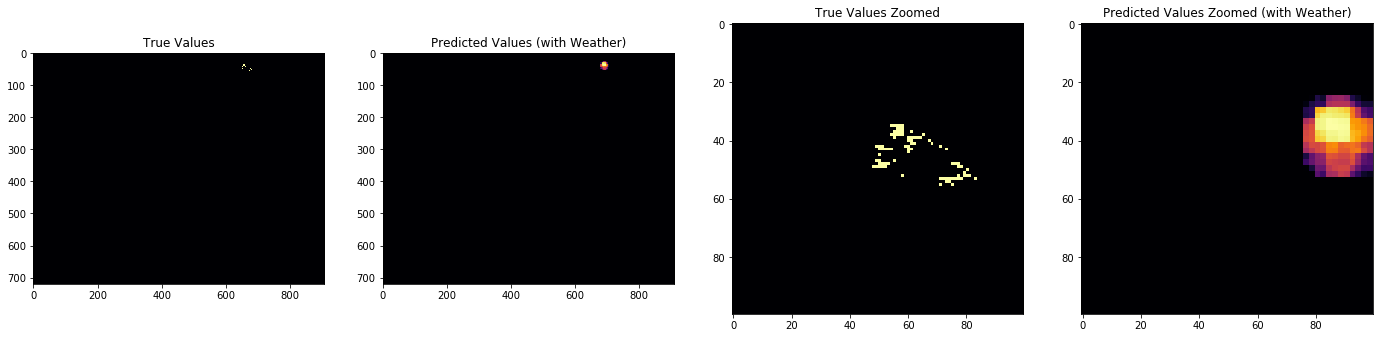

In [129]:
# show results
m = l[0:100, 600:700]
images_3 = [a, l, b, m]
titles_3 = ["True Values", "Predicted Values (with Weather)", "True Values Zoomed", "Predicted Values Zoomed (with Weather)"]
show_images(images_3, titles=titles_3)

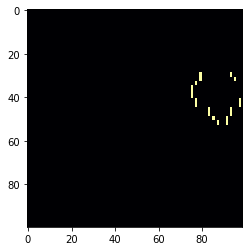

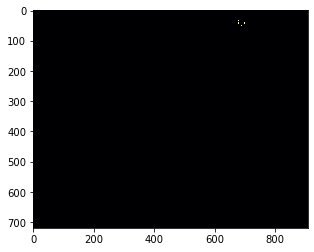

In [130]:
# get outline of fire

# zoomed
n = np.rint(m)
n = np.diff(n)
n = np.abs(n)
plt.imshow(n, cmap='inferno', interpolation='nearest')
plt.show()

# not zoomed
o = np.rint(l)
o = np.diff(o)
o = np.abs(o)
plt.imshow(o, cmap='inferno', interpolation='nearest')
plt.show()

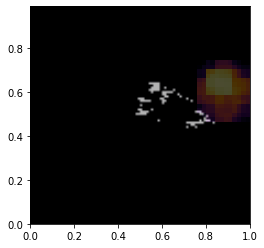

In [131]:
# overlay prediction with actual

extent = np.min(b), np.max(b), np.min(m), np.max(m)

fig = plt.figure(frameon=False)
im1 = plt.imshow(b, cmap='gray', interpolation='bilinear', extent=extent)
im2 = plt.imshow(m, cmap='inferno', interpolation='nearest', extent=extent, alpha=0.3)

plt.show()

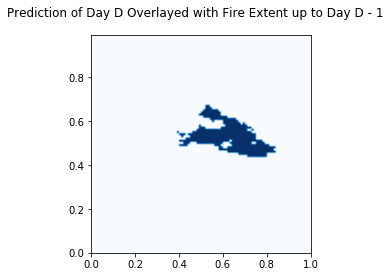

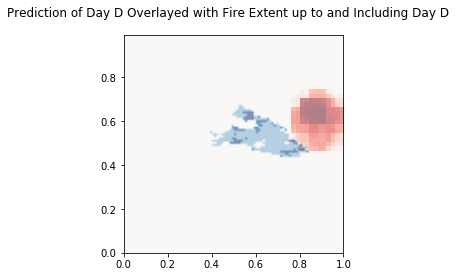

In [132]:
# overlay prediction with previous days of fire

z = fire_data_dict['199']['257'][0:100, 600:700]
y = fire_data_dict['199']['258'][0:100, 600:700]
x = fire_data_dict['199']['259'][0:100, 600:700]
v = fire_data_dict['199']['260'][0:100, 600:700]
u = fire_data_dict['199']['261'][0:100, 600:700]
t = fire_data_dict['199']['262'][0:100, 600:700]
s = fire_data_dict['199']['263'][0:100, 600:700]
r = fire_data_dict['199']['264'][0:100, 600:700]
# q = fire_data_dict['199']['265'][0:100, 600:700]
p = fire_data_dict['199']['266'][0:100, 600:700]
o = fire_data_dict['199']['267'][0:100, 600:700]
n = fire_data_dict['199']['268'][0:100, 600:700]

zz = 0
zz = np.add(z, y)
zz = np.add(zz, x)
zz = np.add(zz, v)
zz = np.add(zz, u)
zz = np.add(zz, t)
zz = np.add(zz, s)
zz = np.add(zz, r)
# zz = np.add(zz, q)
zz = np.add(zz, p)
zz = np.add(zz, o)
zz = np.add(zz, n)

extent = np.min(zz), np.max(zz), np.min(m), np.max(m)

fig2 = plt.figure(frameon=False)
fig2.suptitle("Prediction of Day D Overlayed with Fire Extent up to Day D - 1")
im_203 = plt.imshow(zz, cmap='Blues', interpolation='bilinear', extent=extent)
plt.show()

yy = np.add(zz, b)
fig3 = plt.figure(frameon=False)
im_act = plt.imshow(yy, cmap='Blues', interpolation='bilinear', extent=extent)
im_pred = plt.imshow(m, cmap='Reds', interpolation='nearest', extent=extent, alpha=0.5)
fig3.suptitle("Prediction of Day D Overlayed with Fire Extent up to and Including Day D")
plt.show()

(100, 100)

In [148]:
z = fire_data_dict['199']['257']
y = fire_data_dict['199']['258']
x = fire_data_dict['199']['259']
v = fire_data_dict['199']['260']
u = fire_data_dict['199']['261']
t = fire_data_dict['199']['262']
s = fire_data_dict['199']['263']
r = fire_data_dict['199']['264']
p = fire_data_dict['199']['266']
o = fire_data_dict['199']['267']
n = fire_data_dict['199']['268']

zz = 0
zz = np.add(z, y)
zz = np.add(zz, x)
zz = np.add(zz, v)
zz = np.add(zz, u)
zz = np.add(zz, t)
zz = np.add(zz, s)
zz = np.add(zz, r)
# zz = np.add(zz, q)
zz = np.add(zz, p)
zz = np.add(zz, o)
zz = np.add(zz, n)

In [149]:
def getrasterdims(geotif_filename):
    
    """Get the top left and resolution for pixels in an array
    given the tif coordinate reference system
    Input: geotiff path+filename
    Output: tuple of the x,y coordinate of top left and resolutions of pixel

    Example to find out which pixel a given x,y coordinate refers to:
    pixel_column = (x-left)/xres
    pixel_row = (y-top)/yres
    """

    with rio.open(geotif_filename) as tif:
        profile = tif.profile

    left = profile['transform'][2]
    top = profile['transform'][5]

    xres = profile['transform'][0]
    yres = profile['transform'][4]

    return ((left,top),(xres,yres))

In [207]:
def getcoords(geotif,pixelrow,pixelcol):
    
    """Get the coordinates of a given pixel in the tif coordinate
    system
    Input: geotiff path+filename, and row,column of the pixel in question
    Output: tuple of the x,y coordinate in the geotif coordinate system
    """
    
    with rio.open(geotif) as tif:
        profile = tif.profile

    left = profile['transform'][2]
    top = profile['transform'][5]

    xres = profile['transform'][0]
    yres = profile['transform'][4]

    deltax = xres*pixelcol
    deltay = yres*pixelrow

    x = left+deltax
    y = top+deltay
    
    return (x,y)

In [265]:
%%time
# create outline of predicted burn area
outline = np.rint(zz)
outline = np.diff(outline)
outline = np.abs(outline)

# get raster dims from original tif file
tiff_file = None
path = os.path.abspath(tif_directory)

for f in os.listdir(path):
    if f.endswith('.tif'):
        tiff_file = path + '/' + f
        break
        
raster_dims = getrasterdims(tiff_file)

# get pixels from outline
poly_to_plot = np.where(outline != 0)

# instantiate a matrix in the target shape
shape = outline.shape
poly = np.zeros(shape)

# create a list of coordinates in the tif coordinate system
tif_coordinates = []

for (xi, yi) in list(zip(poly_to_plot[0], poly_to_plot[1])):
    poly[xi,yi] = 1
    coords = getcoords(tiff_file, xi, yi)
    tif_coordinates.append(coords)

CPU times: user 92 ms, sys: 0 ns, total: 92 ms
Wall time: 89.7 ms


In [329]:
lat_long_coords

[(-120.63089414255178, 38.86743631001172),
 (-120.62207064002624, 38.86743631001172),
 (-120.63089414255178, 38.86326036507092),
 (-120.61765888876347, 38.86326036507092),
 (-120.63530589381455, 38.859084420130124),
 (-120.60442363497516, 38.859084420130124),
 (-120.63971764507731, 38.854908475189326),
 (-120.6000118837124, 38.854908475189326),
 (-120.64412939634009, 38.85073253024853),
 (-120.6000118837124, 38.85073253024853),
 (-120.63530589381455, 38.84655658530773),
 (-120.58677662992409, 38.84655658530773),
 (-120.62207064002624, 38.84238064036694),
 (-120.56912962487301, 38.84238064036694),
 (-120.61765888876347, 38.83820469542614),
 (-120.61324713750071, 38.83820469542614),
 (-120.59560013244963, 38.83820469542614),
 (-120.56471787361025, 38.83820469542614),
 (-120.59560013244963, 38.834028750485345),
 (-120.56030612234748, 38.834028750485345),
 (-120.5558943710847, 38.834028750485345),
 (-120.55148261982194, 38.834028750485345),
 (-120.64412939634009, 38.82985280554455),
 (-120

In [266]:
lat_long_coords = tif_coordinates

In [267]:
values = []

for (long, lat) in lat_long_coords:
    index = get_index(tiff_file,long,lat)
    print(index)
    values.append(index)

In [292]:
def predict_day(fire_id, doy, model, matrix_dim):
    '''
    Predicts where fire will be on day "D + 1" for a provided fire_id and day of year, using a provided model.
    
    Args:
        - fire_id: ID of fire to be predicted
        - doy: Day of year to predict fire for
        - model: Model to use for predictions
        - matrix_dim: a hyperparameter for the height and width of the matrices fed into the CNN
    Returns:
        - prediction: numpy matrix of predicted fire probabilities
    '''

    side = int(matrix_dim/2)
    fire_id = str(fire_id)
    doy = str(doy)
    
    try:
        true_fire_map = fire_data_dict[fire_id][doy]
    except KeyError:
        print("Not a valid fire_id and day of year combination")

    weather_data_test = weather_data[doy]
    small_dataset_test = None

    for (day, (x, y)) in small_dataset:
        if day == doy:
            small_dataset_test = (day, (x, y))

    (day, (x, y)) = small_dataset_test
        
    x = np.pad(x, pad_width=matrix_dim, mode='constant', constant_values=0)
    y = np.pad(y, pad_width=matrix_dim, mode='constant', constant_values=0)
    
    print(x.shape)
    
    vals = np.where(y == 1)
    
    x_avg = int(np.mean(vals[0]))
    y_avg = int(np.mean(vals[1]))

    x_min = x_avg - 50
    x_max = x_avg + 50
    
    x_min = max(x_min, 0)
    x_max = min(x_max, 972)
    
    y_min = y_avg - 50
    y_max = y_avg + 50
    
    y_min = max(y_min, 0)
    y_max = min(y_max, 783)
    
    
    x_vals = range(x_min, x_max)
    y_vals = range(y_min, y_max)
    
    vals = list(itertools.product(x_vals, y_vals))
    
    values = []
    
    shape = x.shape
    prediction = np.zeros(shape)
    
    for (xi, yi) in vals:
        point = (xi, yi)
        
        xi_r = xi + side
        xi_l = xi - side
        yi_b = yi + side
        yi_t = yi - side

        m = x[xi_l:xi_r, yi_t:yi_b]
        
        weather = fetch_weather_data(max_values, normalized_weather, doy, xi, yi)

        y_label = y[xi, yi]
        
        if (weather is not None) and (m.shape == (matrix_dim, matrix_dim)):
            values.append((point, y_label, weather, m))
    
    
    for (point, y_label, w, f) in values:        
        fire = []
        weather = []
        Y = []

        fire.append(np.asarray(f))
        weather.append(np.asarray(w))
        Y.append(y_label)

        fire = np.asarray(fire)
        weather = np.asarray(weather)
        Y = np.asarray(Y)
        
        obs = len(fire)
        fire = fire.reshape(obs, matrix_dim, matrix_dim, 1)

        val = model.predict([fire, weather])
            
        prediction[point] = val
    
    x_start = matrix_dim
    x_end = 908 + matrix_dim
    y_start = matrix_dim
    y_end = 719 + matrix_dim
    
    prediction = prediction[y_start:y_end, x_start:x_end]
    
    return prediction

In [306]:
def get_index(long,lat):
    
    """Get the coordinates of a given pixel in the tif coordinate
    system
    Input: geotiff path+filename, and row,column of the pixel in question
    Output: tuple of the x,y coordinate in the geotif coordinate system
    """


    left = -123.50294421461426
    top = 39.00106654811723

    xres = 0.004411751262768785
    yres = -0.0041759449407971815
    
    pixelcol = int(np.rint((long - left)/xres))
    pixelrow = int(np.rint((lat - top)/yres))
    
    return (pixelrow, pixelcol)

In [ ]:
def get_coords(y, x):
    
    """Get the coordinates of a given pixel in the tif coordinate
    system
    Input: geotiff path+filename, and row,column of the pixel in question
    Output: tuple of the x,y coordinate in the geotif coordinate system
    """
    
    with rio.open(geotif) as tif:
        profile = tif.profile

    left = -123.50294421461426
    top = 39.00106654811723

    xres = 0.004411751262768785
    yres = -0.0041759449407971815

    deltax = xres*x
    deltay = yres*y

    x = left+deltax
    y = top+deltay
    
    return (x,y)

In [ ]:
def get_tomorrow_weather(max_values, lat, long):
    
    key = '5ffac5f056d341c6296cba58fa96e9ba'
    lat = str(pair[0])
    long = str(pair[1])
    date = datetime.date.today() + datetime.timedelta(days = 1) 
    blocks = '[currently,minutely,hourly,alerts]'
    units = 'ca'

    # set the query string for darksky
    query = ('https://api.darksky.net/forecast/'+key+'/'+ 
    lat+','+long+','+date+'?exclude=' 
    +blocks+'&units='+units)

    # Make the call to Dark Sky to get all the data for that date and location
    r = s.get(query,headers=headers)

    weather = r.json()
    
    print(weather)

    return weather

In [320]:
def predict_next_day(lat_long_coords):

    today = np.zeros((719, 908))
    
    values = []
    
    for (long, lat) in lat_long_coords:
        index = get_index(long,lat)
        today[index] = 1
        
    np.pad(today, pad_width=matrix_dim, mode='constant', constant_values=0)
    
    vals = np.where(today == 1)
    
    x_avg = int(np.mean(vals[0]))
    y_avg = int(np.mean(vals[1]))

    x_min = x_avg - 50
    x_max = x_avg + 50
    
    x_min = max(x_min, 0)
    x_max = min(x_max, 972)
    
    y_min = y_avg - 50
    y_max = y_avg + 50
    
    y_min = max(y_min, 0)
    y_max = min(y_max, 783)
    
    
    x_vals = range(x_min, x_max)
    y_vals = range(y_min, y_max)
    
    vals = list(itertools.product(x_vals, y_vals))
    
    values = []
    
    shape = today.shape
    prediction = np.zeros(shape)
    
    for (xi, yi) in vals:
        point = (xi, yi)

        xi_r = xi + side
        xi_l = xi - side
        yi_b = yi + side
        yi_t = yi - side

        m = x[xi_l:xi_r, yi_t:yi_b]
        
        (long, lat) = get_coords(x, y)
        
        weather = get_tomorrow_weather(max_values, lat, long)

        y_label = y[xi, yi]

    if (weather is not None) and (m.shape == (matrix_dim, matrix_dim)):
        values.append((point, y_label, weather, m))
    
        
    return pred

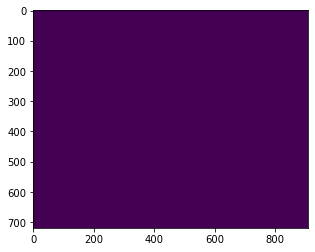

In [321]:
pred = predict_next_day(lat_long_coords)

In [322]:
print(max_values)

{'rainint': 81.55091806687825, 'High T': 317.42411008927, 'Low T': 300.3468885291001, 'Humidity': 1.0, 'Wind Speed': 46.35018731657426, 'Wind Direction': 358.842808170917, 'Fire Direction': 8, 'Fire Speed': 6}


In [328]:
import datetime


2020-04-12


In [323]:
key = '5ffac5f056d341c6296cba58fa96e9ba'
lat = str(pair[0])
long = str(pair[1])
date = datetime.date.today() + datetime.timedelta(days = 1) 
blocks = '[currently,minutely,hourly,alerts]'
units = 'ca'

# set the query string for darksky
query = ('https://api.darksky.net/forecast/'+key+'/'+ 
    lat+','+long+','+date+'?exclude=' 
    +blocks+'&units='+units)

# Make the call to Dark Sky to get all the data for that date and location
r = s.get(query,headers=headers)

weather = r.json()

return weather

In [324]:
def getweather(s,coordinates,date,key):
    """ Function to take the set of coordinates and get the daily
    weather for a given date. rain, hi and low temps, humidity
    wind speed and direction and cloud cover only.
    
    Called from fire_weather
    
    Input: Date, API Key and list of coordinate pairs (lat,long)
    Output: list of jsons
    """
    import requests
    import json
    
    # items to exclude from call
    blocks = '[currently,minutely,hourly,alerts]'

    # Units for call (km/h, deg C, kPa, mm precip)
    units = 'ca'
    
    # Compression for call
    headers = {'Accept-Encoding':'gzip'}
    
    data_out = []
    for pair in coordinates:
        lat = str(pair[0])
        long = str(pair[1])
        # set the query string for darksky
        query = ('https://api.darksky.net/forecast/'+key+'/'+ 
            lat+','+long+','+date+'?exclude=' 
            +blocks+'&units='+units)
        # Make the call to Dark Sky to get all the data for that date and location
        r=s.get(query,headers=headers)
        
        # get the weather data from the request return
        weather=r.json()
        
        # write the jsons as items in the output data list
        data_out.append(weather)
    
    return data_out